# Import Data sets

In [46]:
import pandas as pd
import numpy as np

def extract_G_m_from_data(filepath, customers=[3,4]): #extracts the data of the clients 3 and 4
    # Load the data
    df = pd.read_csv(filepath)

    # Initialize a list to store the data matrices for each client set
    G_m = []

    for customer in customers:
        # Filter out the data for each client
        client_data = df[df['Customer'] == customer]

        # Drop non-consumption columns to leave only the 48 half-hour intervals
        consumption_data = client_data.drop(columns=['Customer', 'Generator Capacity', 'Postcode', 'Consumption Category', 'date', 'Row Quality'])

        # Add the client's consumption data to the G_m list
        G_m.append(consumption_data.to_numpy())

    return G_m


filepath1 = 'first_10_clients_data-11-12.csv' #48d data
filepath2='first_10_clients_data-12-13.csv'



G_m = extract_G_m_from_data(filepath1) #data of 2011-2012
g_DS=extract_G_m_from_data(filepath2) #data of 2012-2013


# AVERAGE ALONG TIME SLOTS + visualize

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def calculate_half_hour_averages(filepath, customer_num):
    # Load the data
    df = pd.read_csv(filepath)

    # Filter the data for the specified customer
    customer_data = df[df['Customer'] == customer_num]

    # Drop non-consumption columns including 'Row Quality'
    consumption_data = customer_data.drop(columns=['Customer', 'Generator Capacity', 'Postcode', 'Consumption Category', 'date', 'Row Quality'])

    # Calculate the average for each half-hour interval
    averages = consumption_data.mean(axis=0)

    return averages


def calculate_average_consumption(client_number, file_path):
    # Load the data
    data = pd.read_csv(file_path)

    # Filter the data for the chosen client
    client_data = data[data['Customer'] == client_number]

    # Select only the time slots columns (from 0:30 to 0:00)
    time_slots = client_data.columns[6:-1]

    # Calculate the average consumption for each time slot
    averages = client_data[time_slots].mean()

    return averages

#This function can be used to visualize the data
def plot_vector(vector):
    times = [(f"{(i // 2) % 24}:{30 if i % 2 else '00'}") for i in range(1, 49)]
    plt.figure(figsize=(15, 5))  # Adjust the figure size as necessary
    plt.bar(times, vector, color='blue')  # You can customize the color
    plt.xlabel('Dimensions')
    plt.ylabel('Values')
    plt.title('Values Across 48 Dimensions')
    plt.xticks(rotation=90)  # Rotate the x labels for better readability
    plt.tight_layout()  # Adjust layout to make room for label rotation
    plt.show()


filepath1 = 'first_10_clients_data-11-12.csv'  
filepath2='first_10_clients_data-12-13.csv'

#below, we are dealing with the 2011-2012 data
averages_G_C1 = calculate_half_hour_averages(filepath1,3) #this is the vector of averages along time-slots of client 1: \underline{g}^1_{\text{avg}} 

averages_G_C2 = calculate_half_hour_averages(filepath1,4) #this is the vector of averages along time-slots of client 2: \underline{g}^2_{\text{avg}} 













# 2 clients 48D case (figures 4a and 4b)

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import cvxpy as cp
from joblib import Parallel, delayed


def remove_negative_values(samples):
    samples = np.asarray(samples)
    samples[samples < 0] = 0
    return samples

# Utility functions
def u_m(x, W, g):
    return -np.linalg.norm((x + g) @ W, 1)

def u_fc(x, g):
    return -np.linalg.norm(np.sum(x + g, axis=0), np.inf)

def u_cvxpy(x, g):
    return -cp.norm(cp.sum(x + g, axis=0), 'inf')

def u_m_cvxpy(x, W, g):
    return -cp.norm((x + g) @ W, 1)

# Function to optimize the decision using cvxpy
def optimize_fc_decision(g, alpha, E_m, d, M, W):
    x = cp.Variable((M, d))
    g = np.array(g).reshape(M, d)
    
    objective = cp.Minimize(
        -cp.sum(cp.multiply(alpha, u_m_cvxpy(x, W, g))) - u_cvxpy(x, g)
    )
    
    constraints = [x >= 0, cp.sum(x, axis=1) >= E_m]
    
    prob = cp.Problem(objective, constraints)
    
    prob.solve(solver=cp.SCS, verbose=False)
    
    if prob.status not in ["infeasible", "unbounded"]:
        return x.value
    else:
        raise ValueError("Optimization failed: " + prob.status)


def water_filling_matrix(matrix: np.ndarray, E_m: float) -> np.ndarray:
    """
    Perform a water-filling algorithm when alpha_m is set to zero.

    Parameters:
    matrix (np.ndarray): The input matrix of the data realizations g.
    E_m (float): Energy constraint.

    Returns:
    np.ndarray: A new matrix with the energy distributed x to maximze the FC's Utility.
    """
    matrix = np.array(matrix)
    num_rows, num_cols = matrix.shape
    new_matrix = np.zeros((num_rows, num_cols))
    
    for i in range(num_rows):
        vector = matrix[i, :]
        n = len(vector)
        highest_value = np.max(vector)
        shaded_area = np.sum([highest_value - v for v in vector])
        
        new_vector = np.zeros(n)
        
        if E_m <= shaded_area:
            remaining_energy = E_m
            sorted_indices = np.argsort(vector)
            cumulative_fill = 0

            for j in range(n):
                idx = sorted_indices[j]
                next_value = vector[sorted_indices[j + 1]] if j < n - 1 else highest_value
                increment = min(next_value - vector[idx], remaining_energy / (j + 1))
                new_vector[sorted_indices[:j + 1]] += increment
                remaining_energy -= increment * (j + 1)

                if remaining_energy <= 0:
                    break
        else:
            filled_vector = np.array([highest_value - v for v in vector])
            remaining_energy = E_m - np.sum(filled_vector)
            
            distributed_energy = remaining_energy / n
            new_vector = filled_vector + distributed_energy
        
        new_matrix[i, :] = new_vector
    
    return new_matrix


def closest_to_global_centrs(point, centroids):
    distances = np.linalg.norm(centroids - point, axis=1)
    closest_index = np.argmin(distances)
    return centroids[closest_index]

def generate_initial_clusters(G_m):
    combined_data = np.vstack(G_m)
    combined_kmeans = KMeans(n_clusters=K).fit(combined_data)
    return combined_kmeans.labels_

def calculate_client_centroids(G_m, initial_clusters, K):
    client_centroids = []
    start_index = 0
    for client_data in G_m:
        client_length = len(client_data)
        client_labels = initial_clusters[start_index:start_index + client_length]
        start_index += client_length
        centroids = np.array([client_data[client_labels == k].mean(axis=0) if np.any(client_labels == k) else np.zeros(client_data.shape[1]) for k in range(K)])
        client_centroids.append(centroids)
    return client_centroids

#this function is used by the client in the heuristic to normalize,shift,scale
def invert_scale_m(A):
    A = np.array(A)
    normalized_A = (A - np.min(A)) / (np.max(A) - np.min(A))
    B = (0.5 - normalized_A)
    return B

#This function is used to create the price matrix with the non-aligment between consumption and price.
def invert_scale_w(A):
    A = np.array(A)
    normalized_A = (A - np.min(A)) / (np.max(A) - np.min(A))
    B = 1.05 - normalized_A
    return B

#this function is used to generate the ordered numbers for the lambda1 and lambda2
def generate_ordered_numbers(a, b, c):
    if a > b:
        raise ValueError("The value of 'a' should be less than or equal to 'b'")
    
    if c < 1:
        raise ValueError("The value of 'c' should be at least 1")
    
    numbers = [0]
    remaining_count = c - 1
    
    if remaining_count > 0:
        random_numbers = np.linspace(a, b, remaining_count)
        numbers.extend(random_numbers)

    numbers = sorted(set(numbers))  # Ensure uniqueness and sort the list
    return numbers

#these vectors apply the heuristic for clients to get the noise vector
mu1_vector=invert_scale_m(averages_G_C1)
mu2_vector=invert_scale_m(averages_G_C2)

def generate_r_k_global(lambdaa1, lambdaa2, client_centroids):
    noise_z1 = np.random.normal(lambdaa1 * mu1_vector, 0.0, (K, 48)) 

    noise_z2 = np.random.normal(lambdaa2*mu2_vector, 0.0, (K, 48))
    
    # Adding noise to client centroids
    client_centroids_noised = np.array([client_centroids[0] + noise_z1, client_centroids[1] + noise_z2]) 
    
    # Ensure no negative values
    client_centroids_noised = remove_negative_values(client_centroids_noised)
    
    # Perform FedAvg: average corresponding centroids across clients
    R_m = np.mean(client_centroids_noised, axis=0)

    return R_m

def simulate_expected_utility_over_means(mean1s, mean2s, W, alpha, E_m, d, M, c_centroids, num_simulations=500, n_jobs=-1):
    expected_utilities_1 = np.zeros((len(mean1s), len(mean2s)))
    expected_utilities_2 = np.zeros((len(mean1s), len(mean2s)))
    mean1s = np.asarray(mean1s)
    mean2s = np.asarray(mean2s)
    zero_index_1 = np.where(mean1s == 0)
    zero_index_2 = np.where(mean2s == 0)
    
    if zero_index_1[0].size == 0:
        raise ValueError("0 is not found in mean1s")
    if zero_index_2[0].size == 0:
        raise ValueError("0 is not found in mean2s")

    zero_index_1 = zero_index_1[0][0]
    zero_index_2 = zero_index_2[0][0]
    def simulate_one_point(mean1, mean2):
        utilities1 = []
        utilities2 = []
        # noise_z2 = noise_vectors[(mean1, mean2)]
        for _ in range(num_simulations):
            g_1 = g_DS[0][np.random.randint(g_DS[0].shape[0]), :]
            g_2 = g_DS[1][np.random.randint(g_DS[1].shape[0]), :]
            g = np.array([g_1, g_2])
            r_k_global = generate_r_k_global(mean2, mean1, c_centroids)
            closest_centroids = [closest_to_global_centrs(g[s], r_k_global) for s in range(M)]
            optimized_x = water_filling_matrix((closest_centroids), E_m)
            # optimized_x = optimize_fc_decision(closest_centroids, alpha, E_m, d, M, W)
            utility_1 = -u_m(optimized_x[0], W, g[0]) #costs of client 1
            utility_2 = -u_m(optimized_x[1], W, g[1])  #costs of client 2
            utilities1.append(utility_1)
            utilities2.append(utility_2)

        mean_utilities = np.mean(utilities1), np.mean(utilities2)
        return mean_utilities, 

    results = Parallel(n_jobs=n_jobs)(delayed(simulate_one_point)(mean1, mean2) for mean1 in mean1s for mean2 in mean2s)
    results = np.array([res[0] for res in results]).reshape(len(mean1s), len(mean2s), 2)
    expected_utilities_1, expected_utilities_2 = results[:, :, 0], results[:, :, 1]
    return expected_utilities_1, expected_utilities_2, zero_index_1, zero_index_2

#lower and upper bounds of lambda1 and lambda2 
lower_bound=-2 
upper_bound=5.5

lambda1_values = generate_ordered_numbers(lower_bound, upper_bound,200)
lambda2_values = generate_ordered_numbers(lower_bound, upper_bound, 200)
alpha = np.array([0.0, 0.0])

E_m=23
d = 48  #number of time-slots/dimesnions
M = 2   #number of clients
K = 4   #number of clusters
D = np.diag(invert_scale_w((averages_G_C1 + averages_G_C2) / 2))*0.5  #price matrix with non-alignment between consumption and price 

initial_clusters = generate_initial_clusters(G_m)
client_centroids = calculate_client_centroids(G_m, initial_clusters, K)

expected_costs_1, expected_costs_2, zero_idx_1, zero_idx_2 = simulate_expected_utility_over_means(
    lambda1_values, lambda2_values, D, alpha, E_m, d, M, client_centroids
)

Nash Equilibrium pairs (mean1, mean2):
(5.5, 5.5)


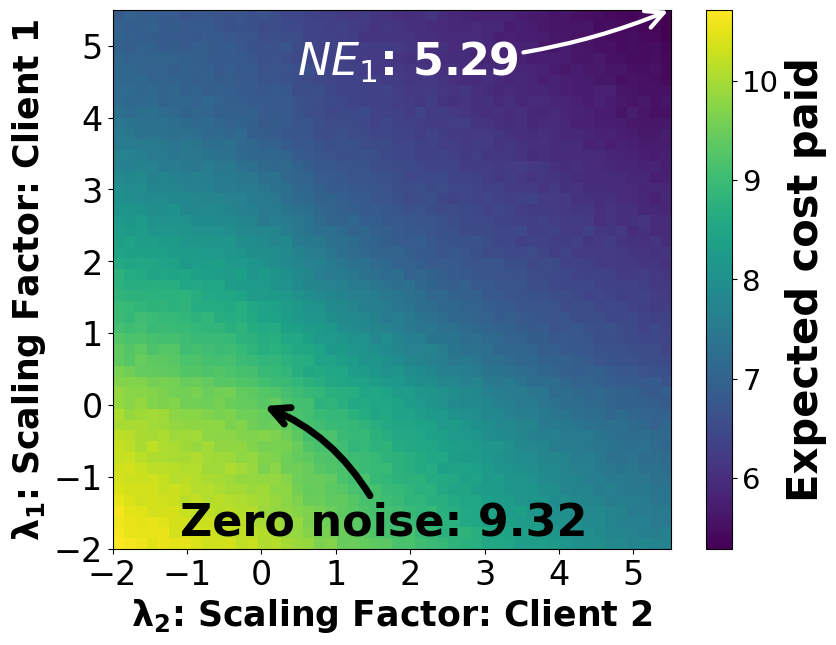

In [49]:
import matplotlib.pyplot as plt
import numpy as np

def plot_heatmap(data, x_ticks, y_ticks, title, xlabel, ylabel, NE_pairs):
    plt.figure(figsize=(9, 7))
    im = plt.imshow(data, cmap='viridis', interpolation='nearest', origin='lower',
                    extent=[x_ticks[0], x_ticks[-1], y_ticks[0], y_ticks[-1]], aspect='auto')

    # Create colorbar with larger font
    cbar = plt.colorbar(im)
    cbar.set_label('Expected cost paid', size=30, weight='bold')  # Adjust size as needed
    cbar.ax.tick_params(labelsize=21)  # Adjust tick size as needed

    # Set larger fonts for labels and title
    plt.xlabel(xlabel, fontsize=25,weight='bold')
    plt.ylabel(ylabel, fontsize=25,weight='bold')

    # Increase tick size
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)

    # Annotate (0,0) specifically
    zero_index_x = np.argmin(np.abs(np.array(x_ticks)))
    zero_index_y = np.argmin(np.abs(np.array(y_ticks)))
    value_at_zero = data[zero_index_y, zero_index_x]
    plt.annotate(f'Zero noise: {value_at_zero:.2f}', xy=(0, 0), xytext=(+235, -100),
                 textcoords='offset points',
                 arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2", color='Black', linewidth=5),
                 ha='right', va='bottom', fontsize=32, color='Black',weight='bold')

    # Annotate Nash Equilibrium (NE) pairs with adjusted positions
    ne_text_offsets = [(-110, -54), (-50, -100), (-10, -160)]  # Different offsets for each NE point
    for i, (ne_x, ne_y) in enumerate(NE_pairs):
        index_x = np.argmin(np.abs(np.array(x_ticks) - ne_x))
        index_y = np.argmin(np.abs(np.array(y_ticks) - ne_y))
        value_at_ne = data[index_y, index_x]
        offset = ne_text_offsets[i % len(ne_text_offsets)]
        plt.annotate(f'$NE_{i+1}$: {value_at_ne:.2f}', xy=(ne_x, ne_y), xytext=offset,
                     textcoords='offset points',
                     arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.1", color='White', linewidth=3),
                     ha='right', va='bottom', fontsize=32, color='White',weight='bold')

    plt.show()

def find_nash_equilibria(expected_costs_1, expected_costs_2, means1, means2):
    NE_pairs = []
    n, m = expected_costs_1.shape
    for i in range(n):
        for j in range(m):
            # Finding the best response for client 1 for a fixed strategy of client 2
            best_response_1 = expected_costs_1[:, j].argmin()
            # Finding the best response for client 2 for a fixed strategy of client 1
            best_response_2 = expected_costs_2[i, :].argmin()

            # If the best response for each client corresponds to the current strategy pair, it is a NE
            if best_response_1 == i and best_response_2 == j:
                NE_pairs.append((float(means1[i]), float(means2[j])))

    return NE_pairs

NE_pairs = find_nash_equilibria(expected_costs_1, expected_costs_2, lambda1_values, lambda2_values)
print("Nash Equilibrium pairs (mean1, mean2):")
for pair in NE_pairs:
    print(pair)

plot_heatmap(expected_costs_1, lambda1_values, lambda2_values,
             title=r'Expected Cost Paid by Client 2 ($\mathbf{-\mathbb{E}(u_1)}$)',
             xlabel=r'$\mathbf{\lambda_2}$: Scaling Factor: Client 2',
             ylabel=r'$\mathbf{\lambda_1}$: Scaling Factor: Client 1',
             NE_pairs=NE_pairs)
